## Identifying fraudulent transactions using DBSCAN
DBSCAN groups together points that are closely packed and marks points that lie alone in low-density regions as outliers. 

In [3]:
import pandas as pd 

df = pd.read_csv("creditcard.csv")

## Feature Engineering

Consider:
- Should we scale our features?
- What features should we include?



In [5]:
target_feature = df["Class"]
input_features = df.drop("Class", axis = 1)

input_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

## Train a DBSCAN model

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps = .5,
                min_samples = 5)

dbscan.fit(input_features)

df["Cluster"] = dbscan.labels_

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Cluster
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,-1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,-1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-1


In [8]:
silhouette_avg = silhouette_score(input_features,
                                  dbscan.labels_)

print(silhouette_avg)

-0.8879779439968847


In [9]:
num_noise_points = np.sum(dbscan.labels_ == -1)
print(num_noise_points)

284671


## Visualize Clusters

AttributeError: module 'matplotlib.pyplot' has no attribute 'colorcar'

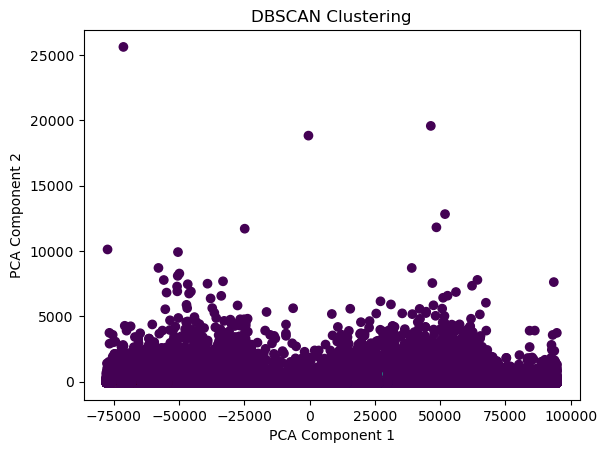

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(input_features)

plt.scatter(pca_data[:, 0], pca_data[:, 1],
            c = dbscan.labels_,
            cmap = 'viridis',
            marker = 'o')

plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorcar(label = 'Cluster Label')

plt.show()